# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать.

Заказчик хочет использовать разработанную модель для имитации технологического процесса.

##  Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

##  Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Файл data_arc_new.csv
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.csv
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.
- Файл data_bulk_time_new.csv
- Скачать файл
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv
- key — номер партии;
- Газ 1 — объём подаваемого газа.
- Файл data_temp_new.csv
- Скачать файл
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

Файл data_wire_new.csv
- key — номер партии;
- Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

Файл data_wire_time_new.csv
- key — номер партии;
- Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Данные также находятся в тренажёре, в папке /datasets/.

##  Цель работы

Достижение на тестовой выборке точности предсказания температуры согласно таблице:

| Оценка                                          | Метрика         |
|:----------------------------------------------- |:---------------:|
| Плохо, на доработку                             | MAE > 6.8       |
| Нормально                                       | 6.3 < MAE ≤ 6.8 |
| Хорошо                                          | 6.0 < MAE ≤ 6.3 |
| Отлично                                         | MAE ≤ 6.0       |

## Импорт библиотек

In [ ]:
# !pip install -q --upgrade scikit-learn imbalanced-learn
# !pip install -q --upgrade pandas
# !pip install -q numpy==1.22.4
# !pip install -q --upgrade feature-engine
# !pip install -q phik imblearn optuna feature_engine category_encoders

In [ ]:
# Импорт необходимых библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict

# Для взаимодействия с БД
import psycopg2

# Для измерения корреляции
from phik.report import correlation_report, plot_correlation_matrix

# Для разделения данных и поиска по сетке
from sklearn.model_selection import train_test_split

# Для предварительной обработки данных
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Для конвейеров
from sklearn.compose   import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline  import Pipeline
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

# Модели машинного обучения
from sklearn.linear_model import Ridge
from sklearn.tree         import DecisionTreeRegressor
from sklearn.ensemble     import VotingRegressor

# Метрики
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold

# Другие модели машинного обучения
from xgboost  import XGBRegressor, callback
from lightgbm import LGBMRegressor

# Оптимизация гиперпараметров
import optuna

# Выбор функций
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures

# Кодирование категориальных признаков
from category_encoders import TargetEncoder

# Для статистических функций
from scipy import stats
from scipy import special

In [ ]:
RANDOM_STATE = 150724

## Конфигурация подключения и загрузка данных из базы данных
- Загрузка данных из БД

In [ ]:
# Конфигурация подключения
db_config = {
    'user':     'user',
    'password': 'Sdf4$2;d-password',
    'host':     'host',
    'port':     'port',
    'database': 'data-science-final'
}

# Список таблиц для загрузки
tables = [
    "data_arc",
    "data_bulk",
    "data_bulk_time",
    "data_gas",
    "data_temp",
    "data_wire",
    "data_wire_time"
]

In [ ]:
# Словарь для хранения DataFrame
dataframes = {}

# Устанавливаем соединение
connection = psycopg2.connect(**db_config)

# Создаем курсор для выполнения операций с базой данных
cursor = connection.cursor()

# Загрузка данных из каждой таблицы и сохранение в DataFrame
for table in tables:
    # Создаем запрос
    query = f"SELECT * FROM steel.{table};"

    # Загружаем данные в DataFrame
    df = pd.read_sql_query(query, connection)

    # Сохраняем DataFrame в словарь
    dataframes[table] = df

In [ ]:
name_space = ['_arc', '_bulk', '_bulk_time', '_gas', '_temp', '_wire', '_wire_time']

# Сформируем dataframe's
for i in name_space:
    globals()['df' + i] = dataframes['data' + i]

## Этап 1: Разведочный анализ данных (EDA)

In [ ]:
def display_dataframe_info(dataframe, description="Описание датафрейма"):
    """
    Description:
        Отображает комплексную информацию о заданном датафрейме pandas.

    Args:
        dataframe (pd.DataFrame): Датафрейм pandas для анализа.
        description (str, optional): Описание датафрейма. По умолчанию "Описание датафрейма".

    Returns:
        None
    """

    # --- ОПИСАНИЕ ---
    print("-" * 80)
    print("ОПИСАНИЕ")
    print("-" * 80)
    print(description)

    # --- ПРЕДПРОСМОТР ДАННЫХ ---
    print("-" * 80)
    print("ПРЕДПРОСМОТР ДАННЫХ")
    print("-" * 80)
    print("Первые 5 строк:")
    print(dataframe.head())
    print("\nПоследние 5 строк:")
    print(dataframe.tail())

    # --- ОБЩАЯ ИНФОРМАЦИЯ ---
    print("-" * 80)
    print("ОБЩАЯ ИНФОРМАЦИЯ")
    print("-" * 80)
    print(f"Размер датафрейма: {dataframe.shape}")
    print(f"Типы данных:\n{dataframe.dtypes}")

    # --- СТАТИСТИКА ОПИСАТЕЛЬНОЙ ---
    print("-" * 80)
    print("СТАТИСТИКА ОПИСАТЕЛЬНОЙ")
    print("-" * 80)
    print(dataframe.describe(include='all'))

    # --- ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ---
    print("-" * 80)
    print("ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
    print("-" * 80)
    missing_percentage = dataframe.isnull().sum() * 100 / len(dataframe)
    print(missing_percentage)

    # --- ДУБЛИКАТЫ ---
    print("-" * 80)
    print("ДУБЛИКАТЫ")
    print("-" * 80)
    print(f"Количество дубликатов: {dataframe.duplicated().sum()}")
    print("-" * 80)

In [ ]:
# Список датафреймов с описаниями
dataframes_info = [
    ("data_arc_new.csv",       "Данные об электродах",                       df_arc),
    ("data_bulk_new.csv",      "Данные о подаче сыпучих материалов (объём)", df_bulk),
    ("data_bulk_time_new.csv", "Данные о подаче сыпучих материалов (время)", df_bulk_time),
    ("data_gas_new.csv",       "Данные о продувке сплава газом",             df_gas),
    ("data_temp_new.csv",      "Результаты измерения температуры",           df_temp),
    ("data_wire_new.csv",      "Данные о проволочных материалах (объём)",    df_wire),
    ("data_wire_time_new.csv", "Данные о проволочных материалах (время)",    df_wire_time),
]

# Цикл для вызова функции display_dataframe_info для каждого датафрейма
for filename, description, dataframe in dataframes_info:
    print(f"----- Информация о файле: {filename} -----\n")
    display_dataframe_info(dataframe, description)
    print("\n\n")

----- Информация о файле: data_arc_new.csv -----

--------------------------------------------------------------------------------
ОПИСАНИЕ
--------------------------------------------------------------------------------
Данные об электродах
--------------------------------------------------------------------------------
ПРЕДПРОСМОТР ДАННЫХ
--------------------------------------------------------------------------------
Первые 5 строк:
   key BeginHeat   EndHeat  ActivePower  ReactivePower
0    1  11:02:14  11:06:02     0.976059       0.687084
1    1  11:07:28  11:10:33     0.805607       0.520285
2    1  11:11:44  11:14:36     0.744363       0.498805
3    1  11:18:14  11:24:19     1.659363       1.062669
4    1  11:26:09  11:28:37     0.692755       0.414397

Последние 5 строк:
        key BeginHeat   EndHeat  ActivePower  ReactivePower
14871  3241  03:58:58  04:01:35     0.533670       0.354439
14872  3241  04:05:04  04:08:04     0.676604       0.523631
14873  3241  04:16:41  04:19:4

## Общий анализ данных

Представленные датасеты содержат информацию о различных параметрах процесса обработки металла: данные об электродах, подаче сыпучих и проволочных материалов, продувке газом, температуре.

**Основные наблюдения:**

* **Проблемы с данными:**  Обнаружены две основные проблемы: во-первых, много пропущенных значений, особенно в данных о подаче материалов.  Во-вторых, датасеты имеют разное количество наблюдений.

**Дальнейшие шаги:**

1. **Разобраться с пропусками:** Выяснить причину пропусков и выбрать подходящий метод обработки (например, удаление, заполнение, моделирование).
2. **Привести данные в порядок:** Преобразовать столбцы даты и времени в правильный формат.
3. **Объединить датасеты:** Использовать общий ключ для объединения данных и проведения комплексного анализа.
4. **Визуализировать:** Построить графики и диаграммы, чтобы выявить закономерности и взаимосвязи между параметрами.


## Этап 2: Предобработка данных
- данные об электродах

In [ ]:
# Отфильтруем отрицательную реактивную мощность
df_arc = df_arc[df_arc['ReactivePower'] >= 0]

In [ ]:
# Перевод колонок с данными о времени в соответствующий формат
df_arc['BeginHeat'] = pd.to_datetime(df_arc['BeginHeat'], format='%H:%M:%S')

df_arc['EndHeat']   = pd.to_datetime(df_arc['EndHeat'],   format='%H:%M:%S')

In [ ]:
# Создадим колонку длительность плавки
df_arc['Melting_time'] = np.diff(df_arc[['BeginHeat', 'EndHeat']], axis=1).squeeze()

df_arc['Melting_time'] = df_arc['Melting_time'].dt.total_seconds()

In [ ]:
# Выполнение агрегации по колонке "key"
df_arc_agg = df_arc.groupby('key').agg({
    'BeginHeat'    : 'min',
    'EndHeat'      : 'max',
    'ActivePower'  : 'mean',
    'ReactivePower': 'mean',
    'Melting_time' : 'sum'
})


# Вычисление количества плавок
df_arc_agg['Number_of_melts'] =  df_arc.groupby('key').agg({'BeginHeat': 'count'})

# Вычисление длительности плавки
df_arc_agg['Melting_time'] = np.diff(df_arc_agg[['BeginHeat', 'EndHeat']], axis=1).squeeze()

# Перевод длительности плавки в секунды
df_arc_agg['Melting_time'] = df_arc_agg['Melting_time'].dt.total_seconds()

In [ ]:
def plot_dataframe_distributions(df: pd.DataFrame, columns: list, title='Квантильное распределение значений датафрейма'):
    """
    Description:
        Строит графики квантильного распределения для заданных столбцов датафрейма.

    Args:
        df (pandas.DataFrame): Датафрейм для анализа.
        title (str, optional): Заголовок графика.
                                 По умолчанию 'Квантильное распределение значений датафрейма'.
        columns (list): Список столбцов.

    Returns:
        None.

    Raises:
        TypeError: Если df не является pandas.DataFrame.
        KeyError: Если какой-либо из столбцов не найден в датафрейме.

    Examples:
        >>> plot_dataframe_distributions(df_arc1_agg, columns=['Bulk 1', 'Bulk 2'])
    """

    # Проверка типа df
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Аргумент df должен быть pandas.DataFrame")

    # Проверка наличия столбцов в df
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Отсутствуют следующие столбцы в датафрейме: {', '.join(missing_cols)}")

    # Определение количества строк и колонок для субплотов
    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3  # Округляем вверх до ближайшего целого числа
    num_cols = min(num_columns, 3)     # Максимум 3 колонки

    plt.figure(figsize=(15, 5 * num_rows))
    plt.suptitle(title, fontsize=18)

    colors = ['blue', 'red', 'green', 'brown'] * ((num_columns // 4) + 1)  # Расширение списка цветов

    for i, column in enumerate(columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=df[column], orient='horizontal', color=colors[i])
        plt.title(column)
        plt.grid()
        plt.xlabel('Значение')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Оставляет место для заголовка
    plt.show()

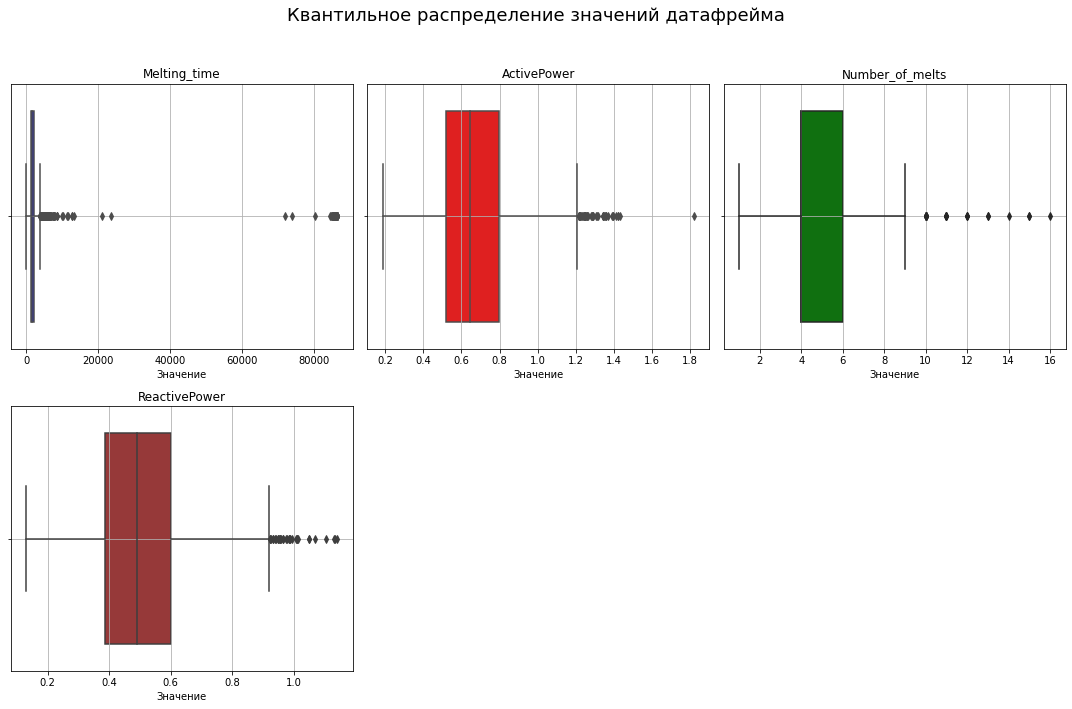

In [ ]:
plot_dataframe_distributions(df = df_arc_agg,
                             columns = ['Melting_time', 'ActivePower', 'Number_of_melts', 'ReactivePower'])

In [ ]:
df_arc_agg[['Melting_time', 'ActivePower', 'Number_of_melts', 'ReactivePower']].describe().T

,count,mean,std,min,25%,50%,75%,max
Melting_time,3214.0,3323.459241,10976.022379,57.000000,1261.250000,1668.000000,2329.000000,86331.000000
ActivePower,3214.0,0.671067,0.207490,0.186226,0.519691,0.646633,0.797201,1.819169
Number_of_melts,3214.0,4.628189,1.608866,1.000000,4.000000,4.000000,6.000000,16.000000
ReactivePower,3214.0,0.501532,0.153933,0.130062,0.387213,0.489478,0.599788,1.141721


In [ ]:
# Функция для удаления выбросов
def remove_outliers(df, columns):
    """
    Description:
        Удаляет выбросы из заданных столбцов датафрейма, используя межквартильный диапазон (IQR).

    Args:
        df (pandas.DataFrame): Датафрейм для анализа.
        columns (list of str): Список столбцов, из которых необходимо удалить выбросы.

    Returns:
        pandas.DataFrame: Датафрейм без выбросов в указанных столбцах.

    Raises:
        TypeError: Если df не является pandas.DataFrame или columns не является списком строк.
        KeyError:  Если какой-либо из столбцов не найден в датафрейме.

    Examples:
        >>> df_cleaned = remove_outliers(df, ['Melting_time', 'ActivePower', 'Number_of_melts', 'ReactivePower'])
    """
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [ ]:
# Удаляем выбросы для всех интересующих нас столбцов
columns_to_check = ['Melting_time', 'ActivePower', 'Number_of_melts', 'ReactivePower']
df_arc_agg = remove_outliers(df_arc_agg, columns_to_check)

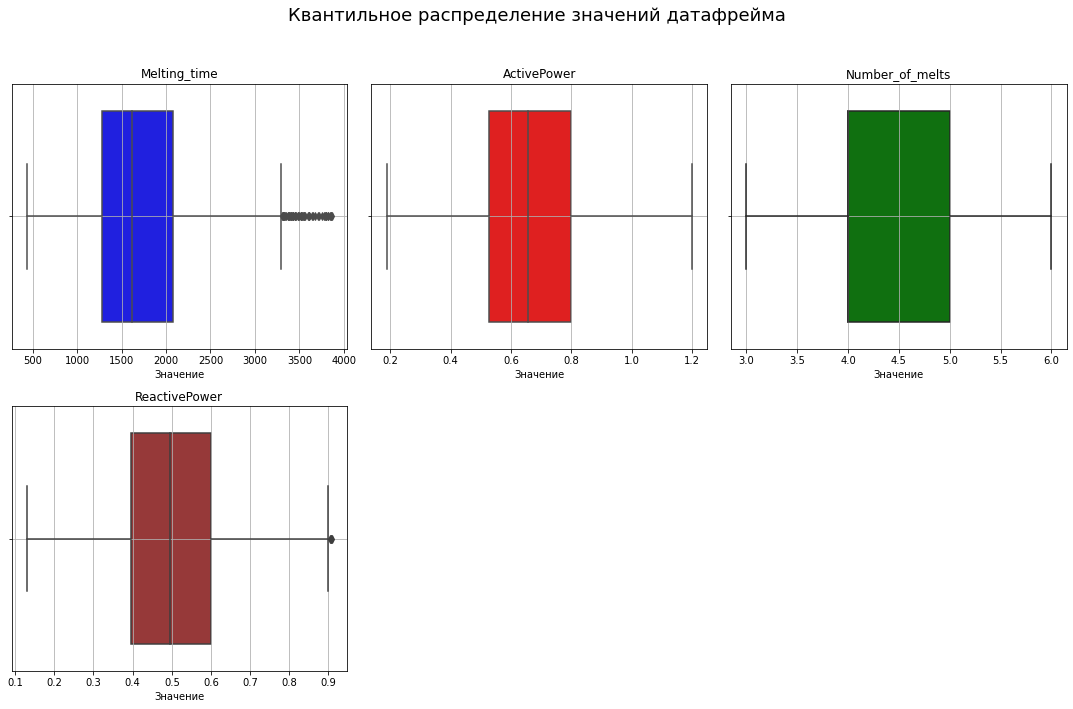

In [ ]:
plot_dataframe_distributions(df = df_arc_agg,
                             columns = ['Melting_time', 'ActivePower', 'Number_of_melts', 'ReactivePower'])

In [ ]:
# Мы потеряли незначительное количество данных.
df_arc_agg[['Melting_time', 'ActivePower', 'Number_of_melts', 'ReactivePower']].describe().T

,count,mean,std,min,25%,50%,75%,max
Melting_time,2546.0,1733.974470,635.132574,434.000000,1278.000000,1617.000000,2082.750000,3865.00000
ActivePower,2546.0,0.670941,0.192598,0.187837,0.528098,0.656154,0.798287,1.19896
Number_of_melts,2546.0,4.447368,1.001658,3.000000,4.000000,4.000000,5.000000,6.00000
ReactivePower,2546.0,0.500552,0.141799,0.130062,0.395958,0.495587,0.599304,0.90839


### **Данных о подаче сыпучих материалов (объём)**

In [ ]:
# Заполним все пропуски нулевыми значениями
df_bulk = df_bulk.fillna(0)

In [ ]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


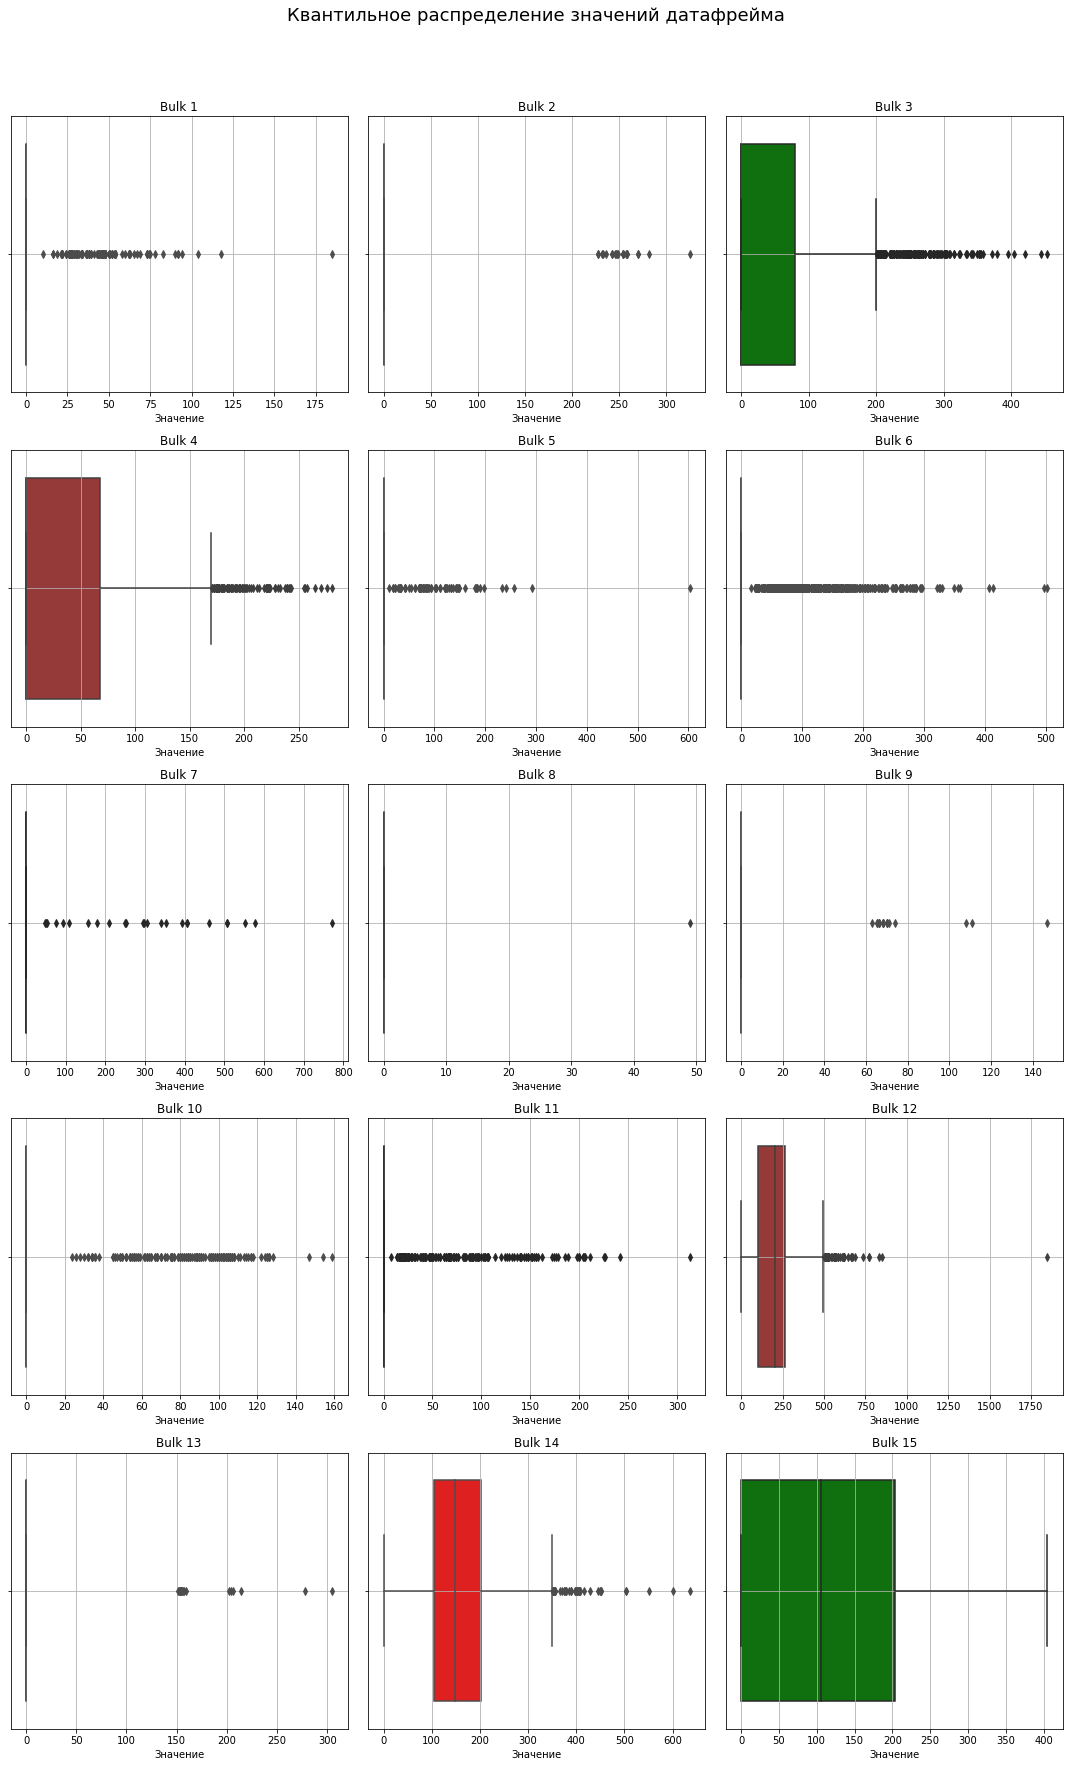

In [ ]:
bulk_list = [
    "Bulk 1", "Bulk 2", "Bulk 3", "Bulk 4", "Bulk 5",
    "Bulk 6", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 10",
    "Bulk 11", "Bulk 12", "Bulk 13", "Bulk 14", "Bulk 15"
]

plot_dataframe_distributions(df = df_bulk,
                             columns = bulk_list)

In [ ]:
# Добавим колонку 'Количество сыпучих материалов'
df_bulk['Quantity_of_bulk_materials'] = df_bulk.sum(axis=1)

In [ ]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Quantity_of_bulk_materials
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271,2219.886865
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698,959.185969
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,1419.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,2220.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,3051.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,4304.000000


In [ ]:
# Превратим ключ в индексы
df_bulk_agg = df_bulk.set_index('key')

In [ ]:
df_bulk_agg.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Quantity_of_bulk_materials
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,554.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,584.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,547.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,599.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,589.0


### **Данные о продувке газом**

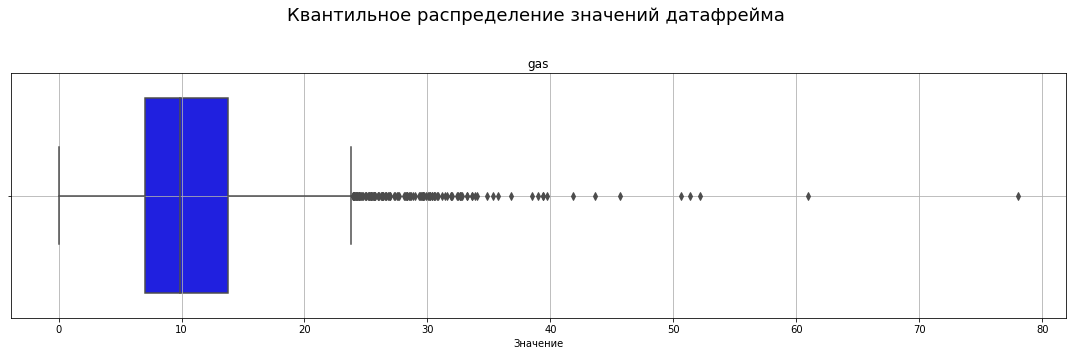

In [ ]:
plot_dataframe_distributions(df = df_gas,
                             columns = ['gas'])

- На графике видны аномалии, однако, поскольку нет выбросов, значительно превышающих нормальное распределение, мы не будем вносить изменения в данные.

In [ ]:
# Превратим ключ в индексы
df_gas_agg = df_gas.set_index('key')

df_gas_agg.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### **Данные об измерениях температуры**

In [ ]:
df_temp.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [ ]:
df_temp['MesaureTime'] = pd.to_datetime(df_temp['MesaureTime'], format='%H:%M:%S')

In [ ]:
df_temp = pd.DataFrame({
    'Time_of_first_measurement':           df_temp.groupby('key')['MesaureTime'].first().values,
    'First_measurement_temperature':       df_temp.groupby('key')['Temperature'].first().values,
    'Time_of_last_measurement':            df_temp.groupby('key')['MesaureTime'].last().values,
    'Temperature_of_the_last_measurement': df_temp.groupby('key')['Temperature'].last().values,
    'Number_of_measurements':              df_temp.groupby('key')['Temperature'].count()
})

In [ ]:
# Выбросим строки с одним замером и с начальной температурой менее 1500
df_temp_agg = df_temp[(df_temp['Number_of_measurements'] > 1) & (df_temp['First_measurement_temperature'] > 1500)]

In [ ]:
df_temp.head()

,Time_of_first_measurement,First_measurement_temperature,Time_of_last_measurement,Temperature_of_the_last_measurement,Number_of_measurements
key,,,,,
1,1900-01-01 11:16:18,1571.0,1900-01-01 11:30:39,1613.0,5
2,1900-01-01 11:37:27,1581.0,1900-01-01 11:59:12,1602.0,6
3,1900-01-01 12:13:17,1596.0,1900-01-01 12:34:57,1599.0,5
4,1900-01-01 12:52:57,1601.0,1900-01-01 12:59:25,1625.0,3
5,1900-01-01 13:23:19,1576.0,1900-01-01 13:36:01,1602.0,2


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Целевой признак выбран корректно

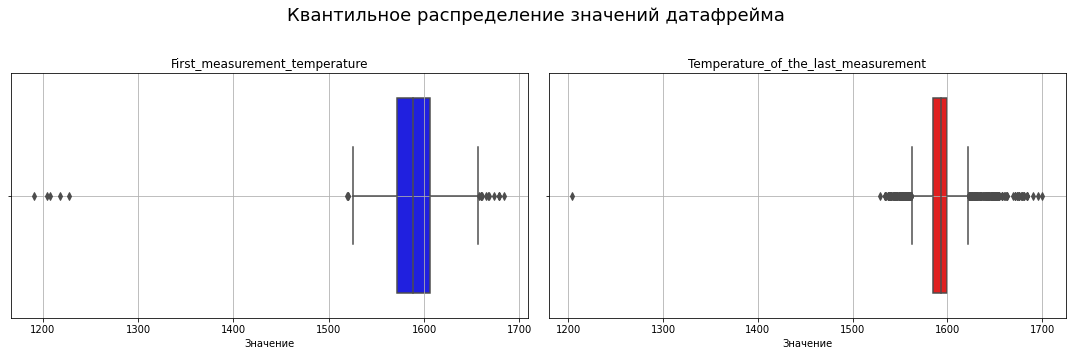

In [ ]:
plot_dataframe_distributions(df = df_temp,
                             columns = ['First_measurement_temperature', 'Temperature_of_the_last_measurement'])

- На графике видны аномалии, однако, поскольку нет выбросов, значительно превышающих нормальное распределение, мы не будем вносить изменения в данные.

### **Данные о проволочных материалах**

In [ ]:
# Заполним все пропуски нулевыми значениями
df_wire = df_wire.fillna(0)

In [ ]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


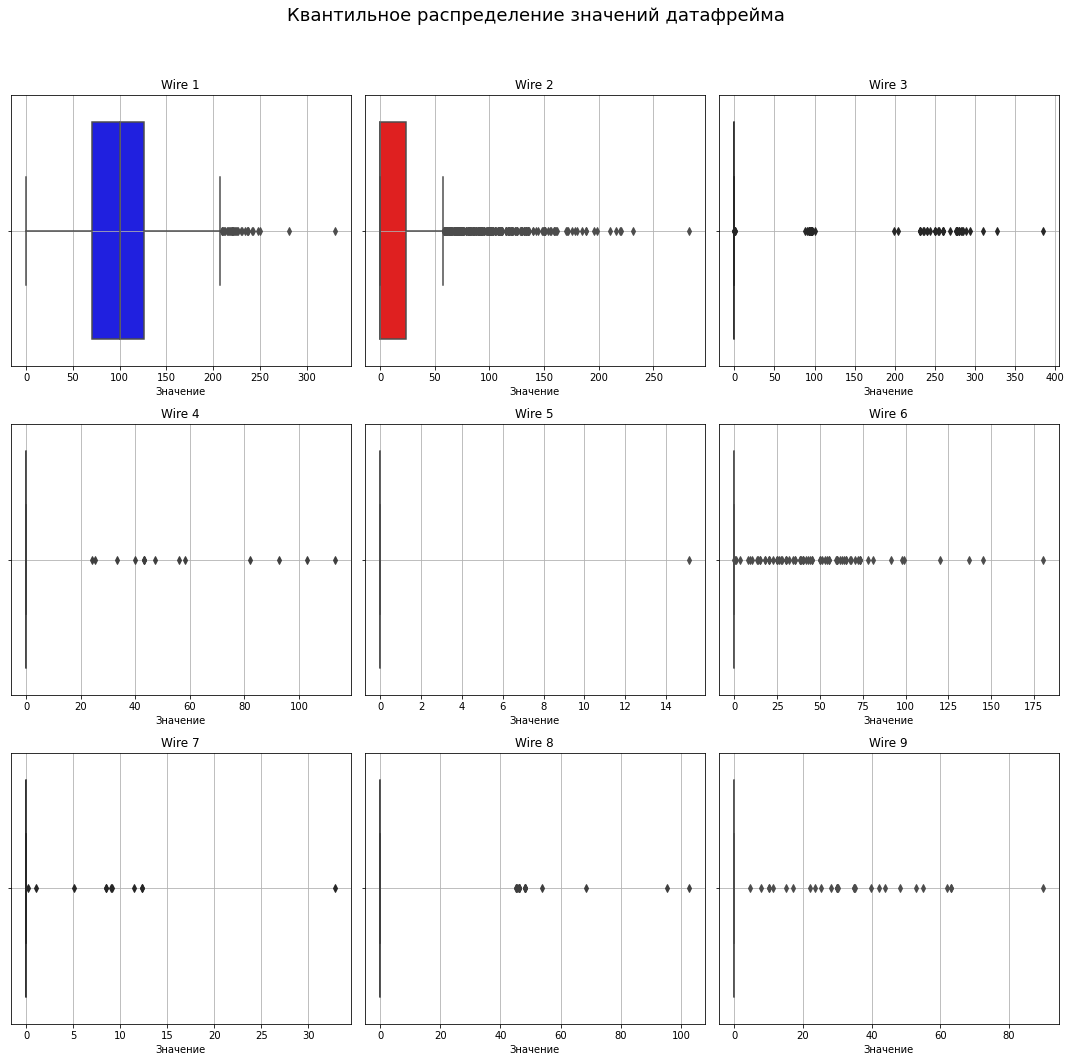

In [ ]:
wires_list = [
    "Wire 1",
    "Wire 2",
    "Wire 3",
    "Wire 4",
    "Wire 5",
    "Wire 6",
    "Wire 7",
    "Wire 8",
    "Wire 9"
]

plot_dataframe_distributions(df = df_wire,
                             columns = wires_list)

In [ ]:
df_wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.00000,1619.000000,2434.000000,3241.000000
Wire 1,3081.0,100.044411,42.841120,0.0,70.28112,100.114563,125.798405,330.314424
Wire 2,3081.0,17.712733,33.517734,0.0,0.00000,0.000000,23.162880,282.780152
Wire 3,3081.0,3.874524,30.310417,0.0,0.00000,0.000000,0.000000,385.008668
Wire 4,3081.0,0.261019,4.293865,0.0,0.00000,0.000000,0.000000,113.231044
Wire 5,3081.0,0.004911,0.272615,0.0,0.00000,0.000000,0.000000,15.132000
Wire 6,3081.0,1.137695,8.958111,0.0,0.00000,0.000000,0.000000,180.454575
Wire 7,3081.0,0.035842,0.774190,0.0,0.00000,0.000000,0.000000,32.847674
Wire 8,3081.0,0.330697,4.392677,0.0,0.00000,0.000000,0.000000,102.762401
Wire 9,3081.0,0.321492,3.806904,0.0,0.00000,0.000000,0.000000,90.053604


- Wire 4, Wire 5, Wire 7, Wire 8, Wire 9: эти переменные имеют очень низкие средние значения и высокие нулевые значения. Если большинство значений равны нулю или близки к нулю, эти переменные могут не содержать полезной информации и могут быть исключены.

In [ ]:
# Добавим колонку 'Количество проволоки'
df_wire['Number_of_wires'] = df_wire.sum(axis=1)

In [ ]:
# Удалим колонки Wire 4, Wire 5, Wire 7, Wire 8, Wire 9
df_wire = df_wire.drop(["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis=1)

In [ ]:
# Превратим ключ в индексы
df_wire_agg = df_wire.set_index('key')

In [ ]:
df_wire_agg.head()

,Wire 1,Wire 2,Wire 3,Wire 6,Number_of_wires
key,,,,,
1,60.059998,0.00000,0.0,0.0,61.059998
2,96.052315,0.00000,0.0,0.0,98.052315
3,91.160157,0.00000,0.0,0.0,94.160157
4,89.063515,0.00000,0.0,0.0,93.063515
5,89.238236,9.11456,0.0,0.0,103.352796


### **Агрегация всех датафремов по ключу**

In [ ]:
def plotHistNumCols(df: pd.DataFrame, graph_width: int, graph_height: int) -> None:
    """
    Description:
        Функция для построения гистограмм числовых столбцов DataFrame.

    Args:
        df: DataFrame, содержащий данные для построения гистограмм.
        graph_width: Ширина графика.
        graph_height: Высота графика.

    Returns:
        None

    Raises:
        TypeError: Если df не является экземпляром pd.DataFrame или graph_width и graph_height не являются int.

    Examples:
        >>> df = pd.DataFrame({
        ...     'col1': [1, 2, 3, 4, 5],
        ...     'col2': [2, 3, 4, 5, 6]
        ... })
        >>> plotHistNumCols(df, 10, 8)
    """
    # Проверка, что df является DataFrame
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Аргумент df должен быть типа pd.DataFrame.")

    # Проверка, что graph_width и graph_height являются целыми числами
    if not isinstance(graph_width, int) or not isinstance(graph_height, int):
        raise TypeError("Аргументы graph_width и graph_height должны быть типа int.")

    # Создание фигуры с заданными размерами
    fig = plt.figure(figsize=(graph_width, graph_height))

    # Построение гистограмм для каждого столбца в DataFrame
    for i, var in enumerate(df.columns):
        ax = fig.add_subplot(8, 4, i + 1)
        df[var].hist(bins=50, ax=ax)
        ax.set_title(var)

    plt.tight_layout()
    plt.show()

In [ ]:
df = df_temp.join([df_arc_agg, df_bulk_agg, df_gas_agg, df_wire_agg], how='inner')

In [ ]:
# Удаление строк с отсутствующими значениями температуры
df = df.dropna(subset=['First_measurement_temperature', 'Temperature_of_the_last_measurement'])

In [ ]:
# Удаление строк с индексами >= 2500
df = df[df.index < 2500]

In [ ]:
# Удалим колонки с данными о времени, так как они не несут информации модели, так же удалим количество замеров
df = df.drop(['Time_of_first_measurement',
              'Time_of_last_measurement',
              'BeginHeat',
              'EndHeat',
              'Number_of_measurements'], axis=1)

In [ ]:
df.head()

,First_measurement_temperature,Temperature_of_the_last_measurement,ActivePower,ReactivePower,Melting_time,Number_of_melts,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 13,Bulk 14,Bulk 15,Quantity_of_bulk_materials,gas,Wire 1,Wire 2,Wire 3,Wire 6,Number_of_wires
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.975629,0.636648,1583.0,5,0.0,0.0,0.0,43.0,...,0.0,150.0,154.0,554.0,29.749986,60.059998,0.00000,0.0,0.0,61.059998
2,1581.0,1602.0,0.763150,0.499528,1144.0,4,0.0,0.0,0.0,73.0,...,0.0,149.0,154.0,584.0,12.555561,96.052315,0.00000,0.0,0.0,98.052315
3,1596.0,1599.0,0.505176,0.319815,1525.0,5,0.0,0.0,0.0,34.0,...,0.0,152.0,153.0,547.0,28.554793,91.160157,0.00000,0.0,0.0,94.160157
4,1601.0,1625.0,0.802313,0.515074,1093.0,4,0.0,0.0,0.0,81.0,...,0.0,153.0,154.0,599.0,18.841219,89.063515,0.00000,0.0,0.0,93.063515
5,1576.0,1602.0,0.836793,0.563161,1362.0,4,0.0,0.0,0.0,78.0,...,0.0,151.0,152.0,589.0,5.413692,89.238236,9.11456,0.0,0.0,103.352796


In [ ]:
df.tail()

,First_measurement_temperature,Temperature_of_the_last_measurement,ActivePower,ReactivePower,Melting_time,Number_of_melts,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 13,Bulk 14,Bulk 15,Quantity_of_bulk_materials,gas,Wire 1,Wire 2,Wire 3,Wire 6,Number_of_wires
key,,,,,,,,,,,,,,,,,,,,,
2495,1570.0,1591.0,0.802673,0.590194,1208.0,4,0.0,0.0,21.0,0.0,...,0.0,129.0,223.0,3214.0,7.125735,89.150879,0.00000,0.0,0.0,2584.150879
2496,1554.0,1591.0,0.700511,0.468364,1406.0,6,0.0,0.0,0.0,63.0,...,0.0,129.0,226.0,3292.0,9.412616,114.179527,0.00000,0.0,0.0,2610.179527
2497,1571.0,1589.0,0.737460,0.617090,764.0,3,0.0,0.0,0.0,85.0,...,0.0,124.0,226.0,3162.0,6.271699,94.086723,9.04800,0.0,0.0,2600.134723
2498,1591.0,1594.0,0.681745,0.471086,1358.0,5,0.0,0.0,90.0,0.0,...,0.0,129.0,207.0,3231.0,14.953657,118.110717,0.00000,0.0,0.0,2616.110717
2499,1569.0,1603.0,1.024608,0.694466,1366.0,4,0.0,0.0,47.0,0.0,...,0.0,126.0,227.0,3132.0,11.336151,110.160958,50.00528,0.0,0.0,2659.166238


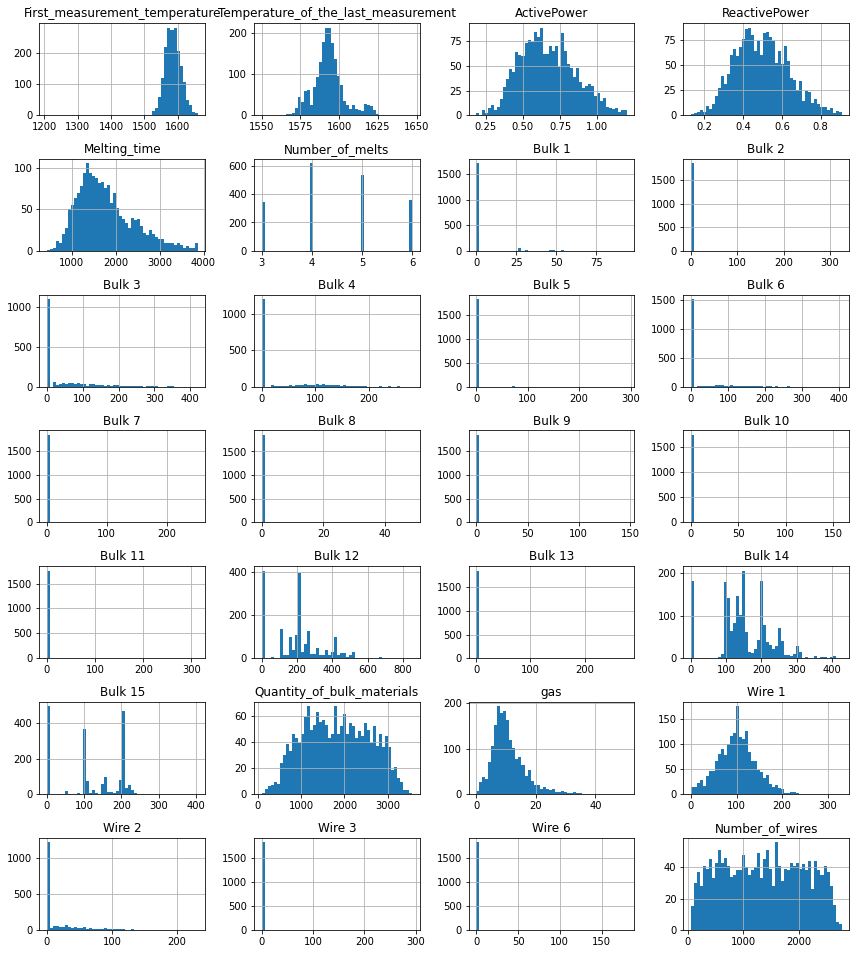

In [ ]:
plotHistNumCols(df, 12, 15)

In [ ]:
def plot_correlation_matrix(df: pd.DataFrame, graph_width: int) -> None:
    """
    Description:
        Строит тепловую диаграмму корреляционной матрицы для заданного DataFrame.

    Args:
        df: DataFrame, содержащий данные для построения матрицы корреляций.
        graph_width: Ширина графика.

    Returns:
        None

    Raises:
        ValueError: Если DataFrame пустой или содержит менее двух столбцов.

    Examples:
        >>> data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
        >>> df = pd.DataFrame(data)
        >>> plot_correlation_matrix(df, 10)
    """
    if df.empty or df.shape[1] < 2:
        raise ValueError("DataFrame должен содержать хотя бы два столбца и не быть пустым.")

    filename = 'Матрица корреляции'
    corr = df.corr()

    plt.figure(num=None, figsize=(graph_width, graph_width), dpi=80, facecolor='w', edgecolor='k')
    corr_mat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=14)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=14)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corr_mat)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            text = f'{corr.iloc[i, j]:.2f}'
            plt.text(j, i, text, ha='center', va='center', color='black')

    plt.title(f'{filename}', fontsize=35)
    plt.show()

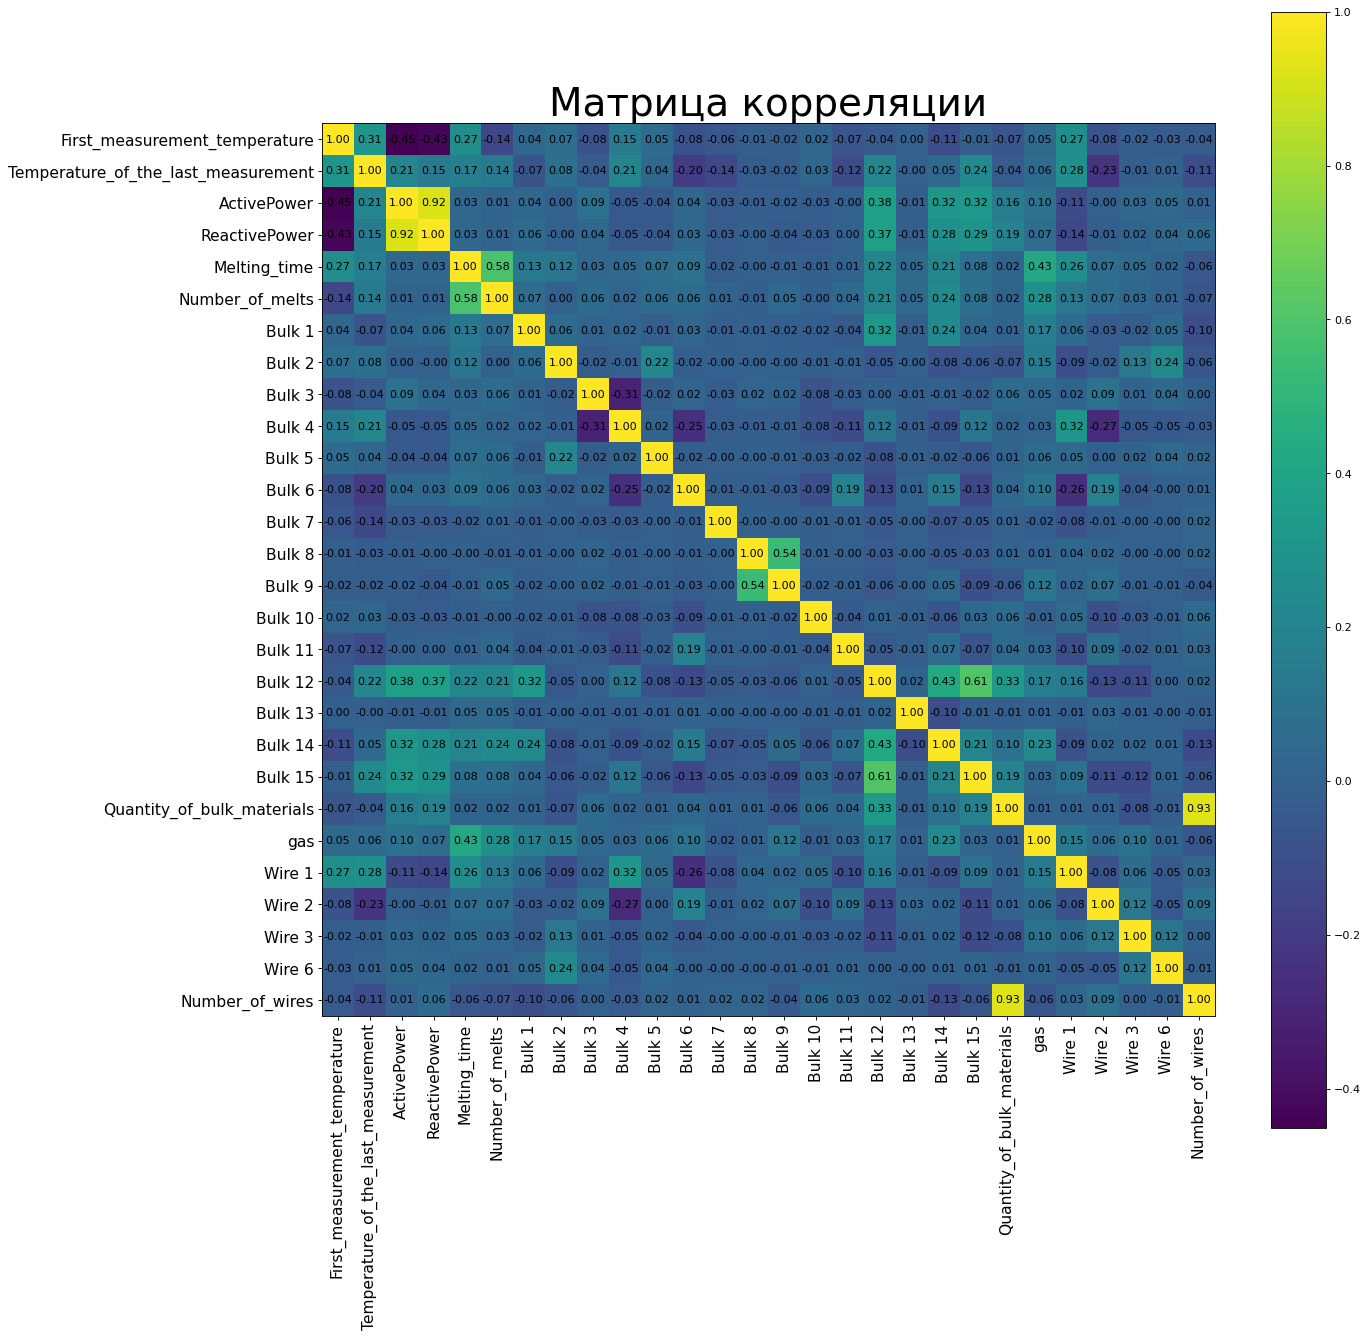

In [ ]:
# Посмотрим корреляцию
plot_correlation_matrix(df, 18)

### **Вывод**

Произведен анализ цикла плавки с использованием временных данных, который позволил установить, что для формирования целевого признака следует использовать последнюю температуру в партии, а первую температуру партии можно включить в набор обучающих признаков. Промежуточные температуры рекомендуется удалить.

В ходе предобработки данных были созданы новые признаки, включая длительность цикла, активное время плавки, количество плавок за цикл, а также общее количество проволоки и сыпучих материалов.

Построена таблица корреляций, в которой обнаружены сильная корреляция между целевым признаком и температурой первого замера, такой признак будет исключен из дальнейшего анализа.

## Этап 3:  **Обучение моделей**

In [ ]:
# Разделение на обучающие и целевые признаки
X = df.drop(['Temperature_of_the_last_measurement', 'First_measurement_temperature'], axis=1)
y = df['Temperature_of_the_last_measurement']

In [ ]:
# Разделение данных на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
# Проверка размеров выборок
print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_temp.shape[0]}")

Размер тренировочной выборки: 1875
Размер тестовой выборки: 625


In [ ]:
def create_pipelines(X_train: pd.DataFrame) -> Pipeline:
    """
    Description:
        Создаёт пайплайны для числовых и категориальных данных и объединяет их в общий пайплайн.

    Args:
        X_train: DataFrame с обучающими признаками.

    Returns:
        Объединённый пайплайн для обработки данных.
    """
    # Список числовых колонок
    num_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()

    # Создание числового пайплайна
    num_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer()),
        ('poly', PolynomialFeatures()),
        ('variance', VarianceThreshold(threshold=0.1))
    ])

    # Список категориальных колонок
    cat_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # Создание категориального пайплайна
    cat_pipeline = Pipeline([
        ('encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer())
    ])

    # Создание ColumnTransformer для применения пайплайнов
    column_transformer = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, num_columns),
            ('cat', cat_pipeline, cat_columns)
        ],
        remainder='passthrough'
    )

    # Создание общего пайплайна
    pipeline = Pipeline([
        ('preprocessor', column_transformer),
        ('variance', VarianceThreshold(threshold=0.1))
    ])

    return pipeline, column_transformer

In [ ]:
# Создание и применение пайплайна
pipeline, column_transformer = create_pipelines(X_train)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('variance',
                                                                   VarianceThreshold(threshold=0.1))]),
                                                  ['ActivePower',
                                                   'ReactivePower',
                                                   'Melting_time',
                                                   'Number_of_melts', 'Bulk 1',
                                                   'Bulk 2', 'Bulk 3', 'Bulk 4',
                                                   'Bulk 5', 'Bulk 6', 'Bulk 7',
                                                   'Bulk 8', 'Bulk 9',
                                                   'Bulk 10', 'Bulk 11',
                                                   'Bulk 12', 'Bulk 13',
                                                   'Bulk 14', 'Bulk 15',
                                                   'Quantity_of_bulk_materials',
                                                   'gas', 'Wire 1', 'Wire 2',
                                                   'Wire 3', 'Wire 6',
                                                   'Number_of_wires']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  [])])),
                ('variance', VarianceThreshold(threshold=0.1))])

In [ ]:
# Трансформируем данные
X_train_transformed = pipeline.transform(X_train)

# Преобразование трансформированных данных в DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed)

In [ ]:
def lgbm_optuna(trial: optuna.Trial) -> float:
    """
    Description:
        Целевая функция для оптимизации гиперпараметров с помощью Optuna.

    Args:
        trial: Экземпляр Optuna Trial для выбора гиперпараметров.

    Returns:
        Средняя MAE на кросс-валидации.
    """
    # Определяем параметры для LGBMRegressor с использованием Optuna
    lgb_params = {
        "learning_rate":    trial.suggest_float("learning_rate", 1e-4, 0.5, log=False),
        "max_depth":        trial.suggest_int("max_depth", 3, 30),
        "n_estimators":     trial.suggest_int("n_estimators", 100, 2000),
        "num_leaves":       trial.suggest_int("num_leaves", 20, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=False),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 1e-5, 10.0, log=False),
        "reg_lambda":       trial.suggest_float("reg_lambda", 1e-5, 10.0, log=False),
        "random_state":     RANDOM_STATE
    }

    # Создаем модель LGBMRegressor с выбранными гиперпараметрами.
    model = LGBMRegressor(**lgb_params)

    # Настраиваем KFold кросс-валидацию с 5 фолдами.
    # Это делается для того, чтобы оценить модель на различных подмножествах данных и избежать переобучения.
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    # Список для хранения MAE для каждой итерации кросс-валидации.
    mae_scores = []

    # Выполняем кросс-валидацию.
    for train_index, valid_index in kf.split(X_train_transformed_df):
        # Разделяем данные на тренировочные и валидационные для текущего фолда.
        X_train_fold, X_valid_fold = X_train_transformed_df.iloc[train_index], X_train_transformed_df.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Обучаем модель на тренировочных данных и оцениваем ее на валидационных данных.
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  verbose=False)

        # Прогнозируем значения на валидационном наборе данных и вычисляем MAE.
        preds = model.predict(X_valid_fold)
        mae = mean_absolute_error(y_valid_fold, preds)
        # Добавляем MAE текущего фолда в список.
        mae_scores.append(mae)

    return np.mean(mae_scores)

In [ ]:
# Оптимизация гиперпараметров LGBMRegressor с помощью Optuna
study = optuna.create_study(direction = "minimize")
study.optimize(lgbm_optuna, n_trials = 42)

In [ ]:
# Вывод лучшего результата
best_params_lgbm = study.best_params
best_mae_lgbm = study.best_value

print(f"Лучшая lgbm MAE на кросс-валидации: {best_mae_lgbm}")

Лучшая lgbm MAE на кросс-валидации: 6.973128454312


In [ ]:
def xgb_optuna(trial: optuna.Trial) -> float:
    """
    Description:
        Целевая функция для оптимизации гиперпараметров XGBRegressor с помощью Optuna.

    Args:
        trial: Экземпляр Optuna Trial для выбора гиперпараметров.

    Returns:
        float: Средняя MAE на валидационной выборке.
    """
    xgb_params = {
        "learning_rate":    trial.suggest_float("learning_rate", 1e-4, 0.3, log=False),
        "max_depth":        trial.suggest_int("max_depth", 3, 20),
        "n_estimators":     trial.suggest_int("n_estimators", 100, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma":            trial.suggest_float("gamma", 0, 1),
        "subsample":        trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "lambda":           trial.suggest_float("lambda", 1e-3, 10, log=False),
        "alpha":            trial.suggest_float("alpha", 1e-3, 10, log=False),
        "n_jobs": -1,
        "eval_metric": "mae"
    }

    # Создаем модель XGBRegressor с выбранными гиперпараметрами.
    model = XGBRegressor(**xgb_params, random_state=RANDOM_STATE)

    # Настраиваем KFold кросс-валидацию с 5 фолдами
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    mae_scores = []

    # Выполняем кросс-валидацию.
    for train_index, valid_index in kf.split(X_train_transformed_df):
        # Разделяем данные на тренировочные и валидационные для текущего фолда.
        X_train_fold, X_valid_fold = X_train_transformed_df.iloc[train_index], X_train_transformed_df.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Обучаем модель на тренировочных данных и оцениваем ее на валидационных данных.
        # Используем раннюю остановку (early_stopping_rounds) для предотвращения переобучения.
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  early_stopping_rounds=10,
                  verbose=False)

        # Прогнозируем значения на валидационном наборе данных и вычисляем MAE.
        preds = model.predict(X_valid_fold)
        mae = mean_absolute_error(y_valid_fold, preds)
        mae_scores.append(mae)

    return np.mean(mae_scores)

In [ ]:
# Оптимизация гиперпараметров XGBRegressor с помощью Optuna
study = optuna.create_study(direction = "minimize")
study.optimize(xgb_optuna, n_trials = 42)

In [ ]:
# Вывод лучшего результата
best_params_xgb = study.best_params
best_mae_xgb = study.best_value

print(f"Лучшая xgb MAE на кросс-валидации: {best_mae_xgb}")

Лучшая xgb MAE на кросс-валидации: 6.134242679421


In [ ]:
def ridge_optuna(trial: optuna.Trial) -> float:
    """
    Description:
        Целевая функция для оптимизации гиперпараметров Ridge с помощью Optuna.

    Args:
        trial: Экземпляр Optuna Trial для выбора гиперпараметров.

    Returns:
        Средняя MAE на кросс-валидации.
    """
    ridge_params = {
        "alpha":         trial.suggest_float("alpha", 1e-5, 100.0, log=False),
        "solver":        trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "normalize":     trial.suggest_categorical("normalize", [True, False]),
        "max_iter":      trial.suggest_int("max_iter", 100, 10000),
        "tol":           trial.suggest_float("tol", 1e-5, 1e-1, log=False)
    }

    # Создаем модель Ridge с выбранными гиперпараметрами.
    model = Ridge(**ridge_params, random_state=RANDOM_STATE)

    # Выполняем кросс-валидацию с 3 фолдами.
    # Используем scoring='neg_mean_absolute_error', так как cross_val_score возвращает отрицательные значения MAE.
    mae_scores = -cross_val_score(model, X_train_transformed, y_train,
                                  scoring='neg_mean_absolute_error', cv=3)

    # Рассчитываем среднюю MAE по всем фолдам как результат работы функции.
    mae = np.mean(mae_scores)

    return mae

In [ ]:
# Оптимизация гиперпараметров Ridge с помощью Optuna
study = optuna.create_study(direction = 'minimize')
study.optimize(ridge_optuna, n_trials = 42)

In [ ]:
# Вывод лучшего результата
best_params_ridge = study.best_params
best_mae_ridge = study.best_value

print(f"Лучшая MAE Ridge на кросс-валидации: {best_mae_ridge}")

Лучшая MAE Ridge на кросс-валидации: 7.815845158901


In [ ]:
def create_model(trial: optuna.Trial) -> Sequential:
    """
    Description:
        Создает и компилирует модель Keras на основе гиперпараметров, предложенных Optuna.

    Args:
        trial: Экземпляр Optuna Trial для выбора гиперпараметров.

    Returns:
        Sequential: Компилированная модель Keras.
    """
    model = Sequential()

    # Гиперпараметры для настройки модели
    n_layers      = trial.suggest_int("n_layers", 1, 3)
    units         = trial.suggest_int("units", 32, 512, log=True)
    dropout       = trial.suggest_float("dropout", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Добавление слоев в модель
    for i in range(n_layers):
        if i == 0:
            # Первый слой с входным размером
            model.add(Dense(units=units, activation='relu', input_dim=X_train.shape[1]))
        else:
            # Скрытые слои
            model.add(Dense(units=units, activation='relu'))
        # Dropout для предотвращения переобучения
        model.add(Dropout(rate=dropout))

    # Выходной слой для регрессии
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)  # Оптимизатор Adam с выбранной скоростью обучения
    model.compile(optimizer=optimizer, loss='mae') # Компиляция модели с MAE в качестве функции потерь


    return model

def nn_optuna(trial: optuna.Trial) -> float:
    """
    Description:
        Целевая функция для оптимизации гиперпараметров Keras модели с помощью Optuna.

    Args:
        trial: Экземпляр Optuna Trial для выбора гиперпараметров.

    Returns:
        float: Средняя MAE на валидационной выборке.
    """
    model = create_model(trial)

    # KFold кросс-валидация для оценки модели
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    mae_scores = []

    for train_index, valid_index in kf.split(X_train_transformed_df):
        X_train_fold, X_valid_fold = X_train_transformed_df.iloc[train_index], X_train_transformed_df.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Обучение модели на текущем фолде
        history = model.fit(X_train_fold, y_train_fold,
                            epochs=100,
                            batch_size=trial.suggest_int("batch_size", 32, 128),
                            validation_data=(X_valid_fold, y_valid_fold),
                            verbose=0,
                            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

        # Прогнозирование и вычисление MAE для текущего фолда
        preds = model.predict(X_valid_fold)
        mae = mean_absolute_error(y_valid_fold, preds)
        mae_scores.append(mae)

    return np.mean(mae_scores)

In [ ]:
# Запуск оптимизации
study = optuna.create_study(direction='minimize')
study.optimize(nn_optuna, n_trials=42)

In [ ]:
# Вывод лучшего результата
best_params_nn = study.best_params
best_mae_nn = study.best_value

print(f"Лучшая MAE NN на кросс-валидации: {best_mae_nn}")

Лучшая MAE NN на кросс-валидации: 9.535801368904


### **Проверка на тестовой выборке**

In [ ]:
# Обучение модели с лучшими гиперпараметрами на всех данных
best_model = XGBRegressor(**best_params_xgb, random_state=RANDOM_STATE)
best_model.fit(X_train_transformed, y_train)

In [ ]:
# Оценка модели на тестовой выборке
test_preds = best_model.predict(X_test_transformed)
test_mae = np.mean(np.abs(y_test - test_preds))

print(f"MAE на тестовой выборке: {test_mae}")

MAE на тестовой выборке: 6.192407136910


### **Проверка на модели-заглушке**

In [ ]:
# Создание и обучение модели-заглушки
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = dummy.predict(X_test)

# Вычисление RMSE
mae_dummy = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_dummy}")

MAE: 11.609407990572369


### **Важность признаков XGB**

In [ ]:
best_model.fit(X_train, y_train)

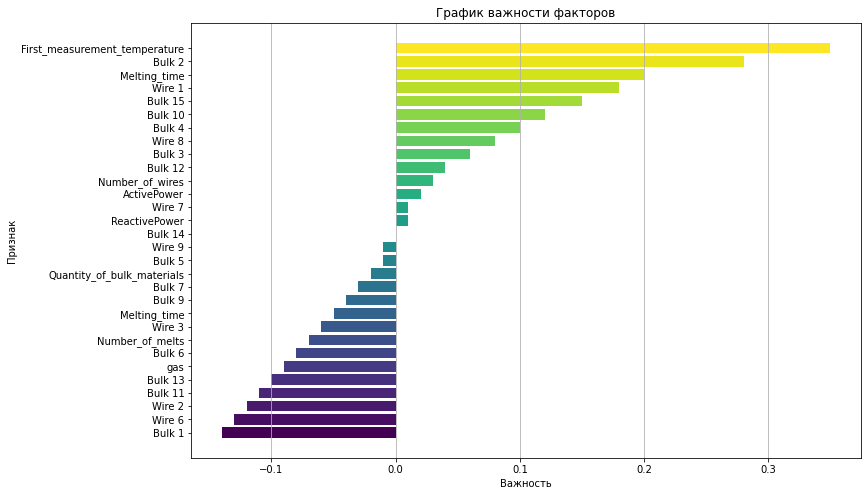

In [ ]:
# Создание датафрейма с признаками и их важностью
imp_df = pd.DataFrame({"Признак":X_train.columns,
                       "Важность":best_model.coef_})

# Сортировка признаков по важности
features = imp_df.sort_values(by="Важность",ascending=False)

# Создание графика важности признаков
plt.figure(figsize=(8,6))
sns.barplot(x="Важность", y="Признак", data=features, palette="plasma")
plt.title("График важности факторов", fontweight="black", size=20, pad=20)
plt.yticks(size=10)
plt.show()

### **Вывод**

В качестве наиболее сильно влияющих параметров выделяется начальная температура и длительность плавки/всего цикла. Эти параметры логичны и кажутся определяющими. Важными также представляются интегральные параметры: количество проволоки и сыпучих материалов.

## Вывод

Построен конвейер, включающий в себя обработку данных и модели. Для трех различных моделей подобраны гиперпараметры. Результаты кросс-валидации сведены в таблицу:

| Модель                                          | MAE             |
|:----------------------------------------------- |:---------------:|
| LightGBM                                        | 6.97            |
| XGB                                             | 6.13            |
| Ridge                                           | 7.81            |
| Sequential                                      | 9.53            |

В качестве лучшей модели была выбрана XGB модель. На тестовой выборке она дала следующие результаты:

| Модель                                          | MAE             |
|:----------------------------------------------- |:---------------:|
| XGB                                             | 6.19            |

XGB модель отвечает требованиям заказчика относительно качества и может быть рекомендована для использования в прогнозировании конечной температуры стали.